#### DS4300 Spring 2024
#### Kaydence Lin
#### HW 3: MongoDB
#### hw3.ipynb

In [1]:
from pymongo import MongoClient
import pymongo
import plotly.graph_objs as go
from IPython.display import display
import plotly.express as px
import json

# inserted restaurant.json file into MongoCompass; database is called 'restaurants'; collection is called 'restaurant'

In [2]:
# connect to mongo and database
client = MongoClient()
db = client.restaurants
collection = db.restaurant

In [3]:
# 1. What restaurants are located in this zip code (user input)?

def zipcodes():
    '''Method to get list of unique zip codes in json'''
    
    zip_lst = collection.distinct('address.zipcode')
    
    return zip_lst

    
def restaurants_zip(zipcode):
    '''Method to get restaurants in a zip code inputted by user and plots location of the restaurant'''
    
    zip_lst = zipcodes()

    if zipcode not in zip_lst:
        print('Invalid zip code. Please enter a valid zip code.')
        return None

    projection = {'name': 1, 'address.building': 1, 'address.street': 1, 'address.coord': 1, '_id': 0}
    query = {'address.zipcode': zipcode, 'name': {'$ne': ''}, 'address.coord': {'$exists': True}}
    restaurants = collection.find(query, projection).sort([('name', 1)])

    # Plot the location of the restaurant using longitude and latitude
    result = []
    lats = []
    longs = []
    for restaurant in restaurants:
        name = restaurant['name']
        address = f"{restaurant['address']['building']} {restaurant['address']['street']}"
        result.append(f"{name}, address: {address}")
        lats.append(restaurant['address']['coord'][1]) 
        longs.append(restaurant['address']['coord'][0]) 

    fig = px.scatter_mapbox(lat=lats, lon=longs, hover_name=result, zoom=12)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(title=f'Restaurants in Zip Code {zipcode}')
    fig.show()

Zip codes in New York City: ['', '07005', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10048', '10057', '10065', '10069', '10075', '10103', '10104', '10106', '10107', '10111', '10112', '10119', '10121', '10122', '10123', '10128', '10153', '10165', '10167', '10168', '10171', '10174', '10280', '10281', '10282', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '10309', '10310', '10311', '10312', '10314', '10317', '10451', '10452', '10453', '10454', '10455', '10456', '10457', '10458', '10459', '10460', '10461', '10462', '10463', '10464', '10465', '10466', '10467', '10468', '10469', '10470', '10471', '10472', '10473', '10474', '10475', '11001', '11004', '110

Enter a zip code:  10009


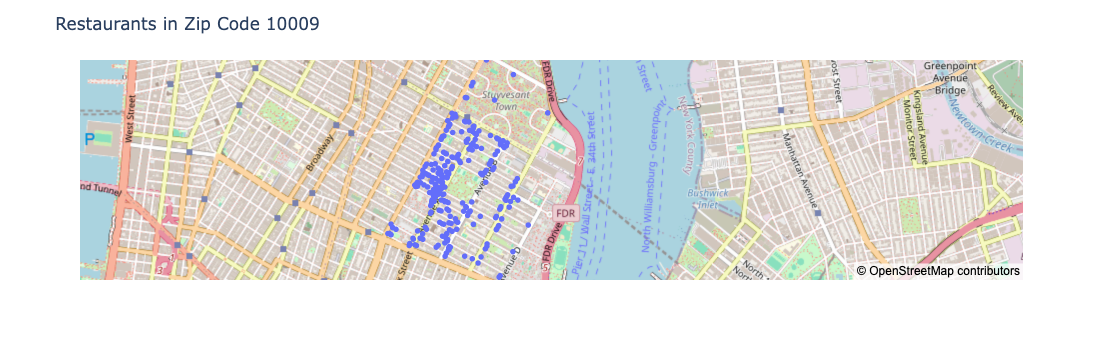

In [4]:
print(f'Zip codes in New York City: {zipcodes()}')
zipcode = input('Enter a zip code: ')
restaurants = restaurants_zip(zipcode)
restaurants

This visualization shows the location of restaurants on a map in a specified zip code. In the zip code 10009, there seems to be
a restaurant at almost every block. People who live here should have plenty of options when eating out. 

In [5]:
# 2. What restaurants have a (user input) grade? --fix, do not get all grades, only most recent

def grades():
    '''Method to get list of unique grades in json'''
    
    grade_lst = collection.distinct("grades.grade")
    
    return grade_lst
    
def restaurants_grade(grade):
    '''Method to get restaurants by user inputted grade'''
    
    query = [{'$unwind': '$grades'},
             {'$match': {'grades.grade': grade, 'name': {'$ne': ''}, 'borough': {'$nin': ['', 'Missing']}}},
             {'$group': {'_id': '$borough', 'count': {'$sum': 1}}}
            ]
    results = collection.aggregate(query)
    
    # Bar chart where x is the borough name and y is the count of restaurants with the grade
    boroughs = []
    counts = []
    for doc in results:
        boroughs.append(doc['_id'])
        counts.append(doc['count'])
    
    fig = go.Figure([go.Bar(x=boroughs, y=counts)])
    fig.update_layout(title=f'Restaurants with Grade {grade} by Borough',
                      xaxis_title='Borough',
                      yaxis_title='Number of Restaurants')

    restaurants_lst = list(collection.find({'grades.grade': grade, 'name': {'$ne': ''}},
                                              {'name': 1, 'borough': 1, '_id': 0}).limit(10))
    
    return restaurants_lst, fig


Health Inspection Grades: ['A', 'B', 'C', 'Not Yet Graded', 'P', 'Z']


Enter a zip code:  B


[{'borough': 'Bronx', 'name': 'Morris Park Bake Shop'}, {'borough': 'Brooklyn', 'name': "Wendy'S"}, {'borough': 'Queens', 'name': 'Tov Kosher Kitchen'}, {'borough': 'Brooklyn', 'name': 'May May Kitchen'}, {'borough': 'Brooklyn', 'name': 'Seuda Foods'}, {'borough': 'Manhattan', 'name': 'Glorious Food'}, {'borough': 'Manhattan', 'name': 'P & S Deli Grocery'}, {'borough': 'Bronx', 'name': 'Happy Garden'}, {'borough': 'Queens', 'name': "Tony'S Deli"}, {'borough': 'Queens', 'name': 'Hot Bagels'}]


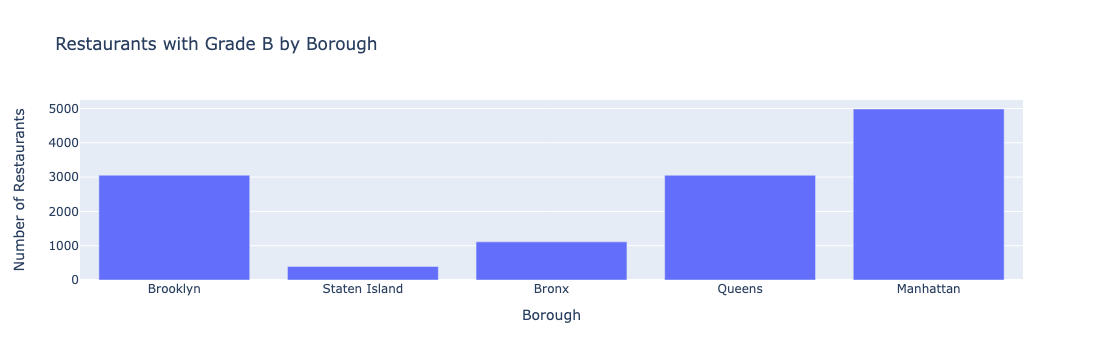

In [6]:
print(f'Health Inspection Grades: {grades()}')
grade = input('Enter a zip code: ')
restaurants = restaurants_grade(grade)
print(restaurants[0])
display(restaurants[1])

This visualization shows the number of restaurants have what grades determined by a user input in each borough. It is shown that
Manhattan has the most number of restaurants with a B grade and Staten Island has the least number of restaurants with a B grade.

In [7]:
# 3. What are the most popular cuisines in (user input borough)?

def borough():
    '''Method to get a list of unique boroughs in json'''
    
    query = [{'$match': {'borough': {'$ne': 'Missing'}}},
                {'$group': {'_id': '$borough'}}
               ]
    
    results = collection.aggregate(query)
    boroughs = [result['_id'] for result in results]
    
    return boroughs

def cuisine_borough(borough):
    '''Method to get most popular cuisines in user inputted borough'''
    query = [{'$match': {'borough': borough}},
             {'$group': {'_id': '$cuisine', 'count': {'$sum': 1}}},
             {'$sort': {'count': -1}},
             {'$limit': 5}
            ]
    results = collection.aggregate(query)
    
    # Bar chart where x is the cuisine and y is the count
    cuisines = []
    counts = []
    for doc in results:
        cuisines.append(doc['_id'])
        counts.append(doc['count'])
    
    # Create a bar chart using Plotly
    fig = go.Figure([go.Bar(x=cuisines, y=counts)])
    fig.update_layout(title=f'Most Popular Cuisines in {borough}',
                      xaxis_title='Cuisine',
                      yaxis_title='Count')
    
    return fig

Boroughs in New York City: ['Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Manhattan']


Enter a borough:  Queens


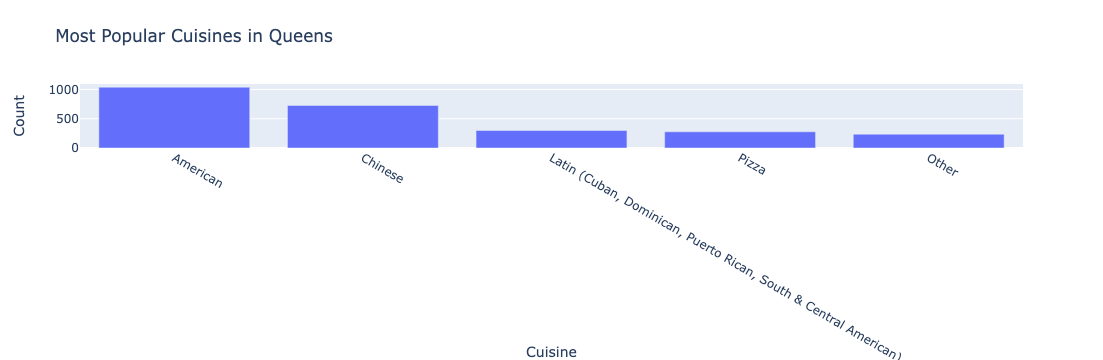

In [8]:
print(f'Boroughs in New York City: {borough()}')
borough_input = input('Enter a borough: ')
cuisines = cuisine_borough(borough_input)
cuisines

This visualization shows the most popular cuisines in a borough given by the user. The most popular cuisines in Queens are
American, Chinese, Latin, and Pizza. 

In [9]:
# 4. What is the average food inspection score in (user inputted borough) by year?

def borough_score(borough):
    '''Method to plot average food inspection scores over the year from user inputted borough'''
    
    query = [{'$match': {'borough': borough}},  
             {'$unwind': '$grades'}, 
             {'$addFields': {'inspection_year': {'$year':'$grades.date'}}},  
             {'$group': {'_id': '$inspection_year', 'avg_score': {'$avg': '$grades.score'}}},  
             {'$sort': {'_id': 1}}  
            ]
    results = collection.aggregate(query)

    # Scatterplot of average scores over the years
    years = []
    avg_scores = []
    for item in results:
        years.append(item['_id'])
        avg_scores.append(item['avg_score'])

    total_avg = sum(avg_scores) / len(avg_scores)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years, y=avg_scores, mode='markers+lines', name='Average Score by Year', line=dict(color='blue', width=2), marker=dict(color='blue', size=10)))
    fig.add_trace(go.Scatter(x=years, y=[total_avg] * len(years), mode='lines', name='Overall Average Score', line=dict(color='red', width=2, dash='dash')))
    
    fig.update_layout(title=f'Average Health Inspection Score by Year in {borough}', xaxis_title='Year', yaxis_title='Average Score')
    fig.show()

Boroughs in New York City: ['Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Manhattan']


Enter a borough:  Bronx


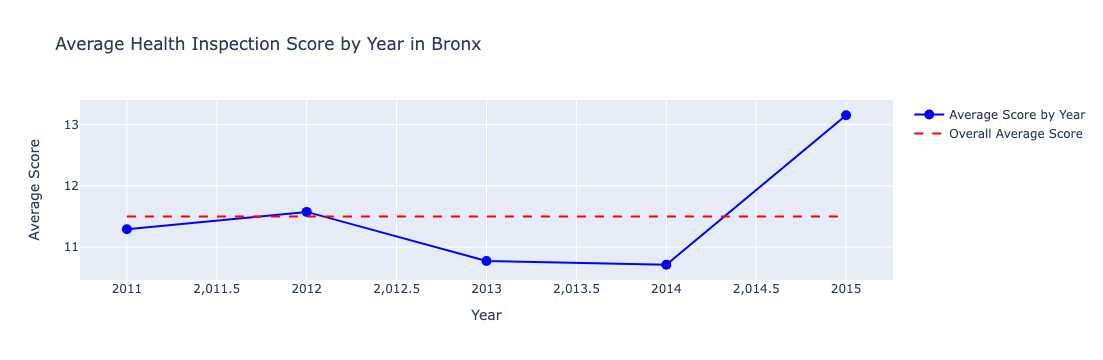

In [10]:
borough_lst = borough()
print(f'Boroughs in New York City: {borough_lst}')
borough_input = input('Enter a borough: ')
plot_borough = borough_score(borough_input)
plot_borough

This visualization shows the average inspection score each year by a borough given by the user. In 2011 and 2012, the average
health inspection score in the Bronx was very close to the overall average. In 2013 and 2014, the scores were below the overall 
average. In 2015, the scores were above the overall average. 

In [11]:
# 5. What is the average food inspection score at (user inputted cuisine) by year?

def cuisines():
    '''Method to get a list of unique cuisines in the json'''
    cuisine_lst = collection.distinct("cuisine")

    return cuisine_lst

def cuisine_score(cuisine):
    '''Method to plot average food inspection scores over the year from user inputted cuisine'''
    
    query = [{'$match': {'cuisine': cuisine}},  
             {'$unwind': '$grades'}, 
             {'$addFields': {'inspection_year': {'$year':'$grades.date'}}},  
             {'$group': {'_id': '$inspection_year', 'avg_score': {'$avg': '$grades.score'}}},  
             {'$sort': {'_id': 1}}  
            ]
    results = collection.aggregate(query)

    # Scatterplot of average scores over the years
    years = []
    avg_scores = []
    for item in results:
        years.append(item['_id'])
        avg_scores.append(item['avg_score'])

    total_avg = sum(avg_scores) / len(avg_scores)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years, y=avg_scores, mode='markers+lines', name='Average Score by Year', line=dict(color='blue', width=2), marker=dict(color='blue', size=10)))
    fig.add_trace(go.Scatter(x=years, y=[total_avg] * len(years), mode='lines', name='Overall Average Score', line=dict(color='red', width=2, dash='dash')))
    
    fig.update_layout(title=f'Average Health Inspection Score by Year for {cuisine} Cuisine', xaxis_title='Year', yaxis_title='Average Score')
    fig.show()


Cuisines: ['Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottled beverages, including water, sodas, juices, etc.', 'Brazilian', 'CafÃ©/Coffee/Tea', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani', 'Pancakes/Waffles', 'Peruvian', 'P

Enter a cuisine:  Mexican


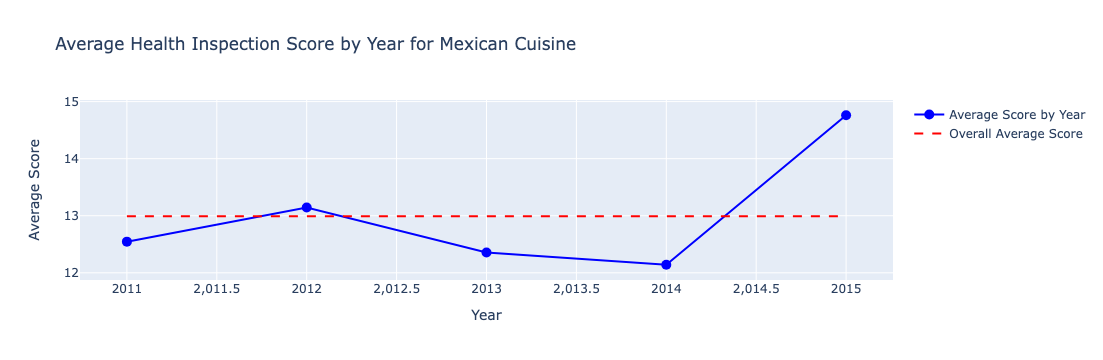

In [12]:
print(f'Cuisines: {cuisines()}')
cuisine_input = input('Enter a cuisine: ')
plot_cuisine = cuisine_score(cuisine_input)
plot_cuisine

This visualization shows the average inspection score each year by a cuisine given by the user. Compared to the graph of the 
scores in the Bronx, the Mexican restaurants follow a similar pattern. This could suggest that some rules and laws were changed regarding
health inspection and food safety during these years.

In [13]:
# 6. What (user input cuisines) are in (user input zipcode)?

def cuisines_zipcode(cuisine, zipcode):
    '''Method to find cuisines available in a specified zip code and plots the location of the restaurant'''
    
    query = [{'$match': {'address.zipcode': zipcode, 'cuisine': cuisine}},
             {'$project': {'_id': 0, 'name': 1, 'location': '$address.coord'}}
            ]    
    results = collection.aggregate(query)
    
    # Plot the location of the restaurant using longitude and latitude
    lats = []
    longs = []
    names = []
    for item in results:
        if item['location']:
            lats.append(item['location'][1]) 
            longs.append(item['location'][0])  
            names.append(item['name'])
    
    fig = px.scatter_mapbox(lat=lats, lon=longs, hover_name=names, zoom=10)
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(title=f'Restaurants serving {cuisine} cuisine in Zip Code {zipcode}')
    fig.show()

Cuisines: ['Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottled beverages, including water, sodas, juices, etc.', 'Brazilian', 'CafÃ©/Coffee/Tea', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani', 'Pancakes/Waffles', 'Peruvian', 'P

Enter a cuisine:  Chinese


Zip codes in New York City: ['', '07005', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10048', '10057', '10065', '10069', '10075', '10103', '10104', '10106', '10107', '10111', '10112', '10119', '10121', '10122', '10123', '10128', '10153', '10165', '10167', '10168', '10171', '10174', '10280', '10281', '10282', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '10309', '10310', '10311', '10312', '10314', '10317', '10451', '10452', '10453', '10454', '10455', '10456', '10457', '10458', '10459', '10460', '10461', '10462', '10463', '10464', '10465', '10466', '10467', '10468', '10469', '10470', '10471', '10472', '10473', '10474', '10475', '11001', '11004', '110

Enter a zip code:  10009


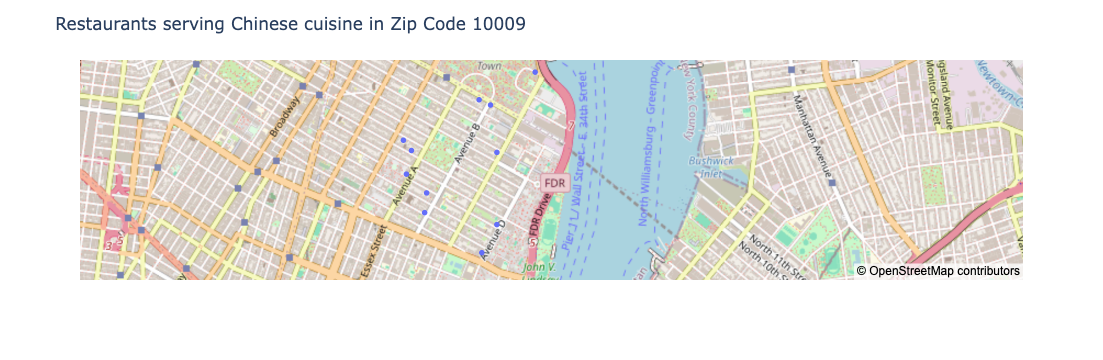

In [14]:
print(f'Cuisines: {cuisines()}')
cuisine_input = input('Enter a cuisine: ')
print(f'Zip codes in New York City: {zipcodes()}')
zipcode_input = input('Enter a zip code: ')
cuisines_zipcode(cuisine_input, zipcode_input)

This visualization shows the locations of the restaurant based on user inputs of cuisine and zip code. In the zip code 10009, 
there do not seem to be a lot of restaurants for Chinese food. They also appear to be scattered around in the area. 

In [15]:
# 7. Which borough has the most (user input cuisine) food?

def boroughs_cuisine(cuisine):
    '''Method to find boroughs with the most restaurants from a user inputted cuisine'''
    
    query = [{'$match': {'cuisine': cuisine}}, 
             {'$group': {'_id': '$borough', 'count': {'$sum': 1}}},  
             {'$sort': {'count': -1}},  
             {'$limit': 5}  
            ]    
    results = collection.aggregate(query)
    
    # Bar chart to plot top boroughs with the cuisine
    boroughs = []
    counts = []
    for item in results:
        boroughs.append(item['_id'])
        counts.append(item['count'])
        
    # Creating a bar plot using Plotly
    fig = px.bar(x=boroughs, y=counts, color=boroughs,
                 labels={'x': 'Borough', 'y': 'Number of Restaurants'},
                 title=f'Boroughs with the Most {cuisine} Food')
    fig.show()

Cuisines: ['Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottled beverages, including water, sodas, juices, etc.', 'Brazilian', 'CafÃ©/Coffee/Tea', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani', 'Pancakes/Waffles', 'Peruvian', 'P

Enter a cuisine:  Brazilian


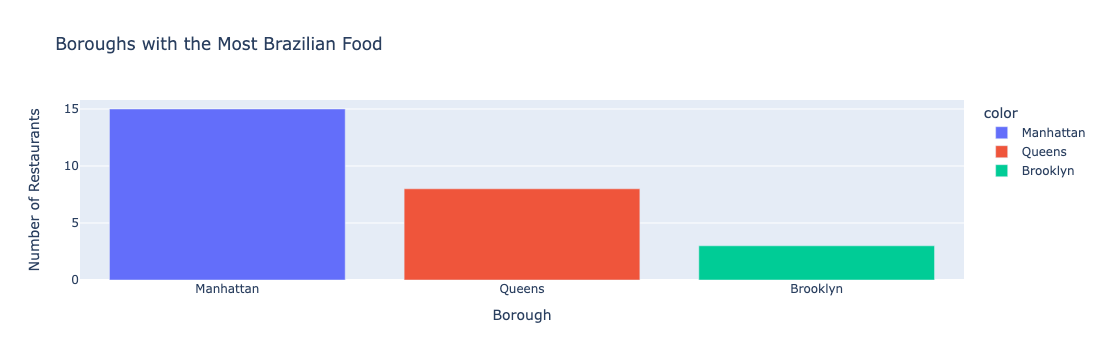

In [16]:
print(f'Cuisines: {cuisines()}')
cuisine_input = input('Enter a cuisine: ')
boroughs_cuisine(cuisine_input)

This visualization shows the boroughs with the most amount of restaurants based on a cuisine a user inputs. This shows that the
boroughs with the most Brazilian restaurants are Manhattan, Queens, and Brooklyn.

In [18]:
# 8. Which zip code has the most number of restaurants?

def most_restaurants():
    '''Method to plot the zip code with the most number of restaurants'''
    
    query = [{'$group': {'_id': '$address.zipcode', 'count': {'$sum': 1}}}, 
             {'$sort': {'count': -1}},  
             {'$limit': 20}
            ]
    results = collection.aggregate(query)
    
    # Bar chart to plot zip code vs. number of restaurants
    zipcodes = []
    counts = []
    for item in results:
        zipcodes.append(item['_id'])
        counts.append(item['count'])
        
    fig = px.bar(x=zipcodes, y=counts,
                 labels={'x': 'Zip Code', 'y': 'Number of Restaurants'},
                 title='Zip Code vs. Number of Restaurants')
    fig.show()

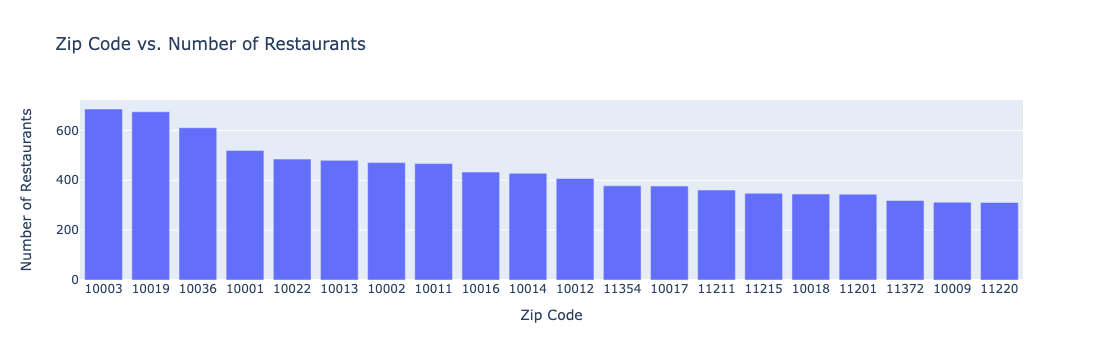

In [19]:
most_restaurants()

This visualization shows the number of restaurants in each zip code. The zip code 10003 has 683 restaurants which is impressive
that a small city by land can fit so many restaurants.

In [20]:
# 9. Which boroughs has the least amount of (user inputted cuisine)?

def boroughs_least(cuisine):
    '''Method to find boroughs with the least amount of a user-inputted cuisine'''

    query = [{'$match': {'cuisine': cuisine}}, 
             {'$group': {'_id': '$borough', 'count': {'$sum': 1}}},  
             {'$sort': {'count': 1}}
            ]
    results = collection.aggregate(query)
    
    # Bar char to plot boroughs with least about of inputted cuisine
    boroughs = []
    counts = []
    for item in results:
        boroughs.append(item['_id'])
        counts.append(item['count'])
        
    min_count = min(counts)
    least_boroughs = [borough for borough, count in zip(boroughs, counts) if count == min_count]
    
    fig = go.Figure(data=go.Bar(x=boroughs, y=counts))
    fig.update_layout(title=f'Boroughs with the Least Amount of {cuisine.capitalize()} Cuisine',
                      xaxis_title='Borough',
                      yaxis_title='Number of Restaurants')
    fig.show()
    
    return least_boroughs

Cuisines: ['Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottled beverages, including water, sodas, juices, etc.', 'Brazilian', 'CafÃ©/Coffee/Tea', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani', 'Pancakes/Waffles', 'Peruvian', 'P

Enter a cuisine:  Thai


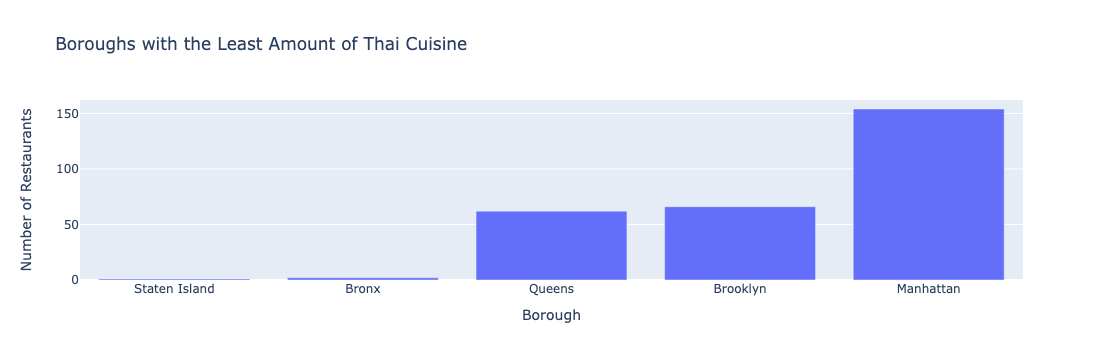

['Staten Island']

In [22]:
print(f'Cuisines: {cuisines()}')
cuisine_input = input('Enter a cuisine: ')
boroughs_least(cuisine_input)

This visualization shows the boroughs with the least amount of a user-inputted cuisine. Staten Island and Bronx has very litte
Thai restaurants compared to the other boroughs. 

In [29]:
# 10. What cuisines are in (user inputted borough)?

def cuisines_in_borough(borough):
    '''Method to find cuisines in a user-inputted borough'''
    
    query = [{'$match': {'borough': borough}}, 
             {'$group': {'_id': '$cuisine', 'count': {'$sum': 1}}},  
             {'$match': {'count': {'$gt': 0}}},  
             {'$sort': {'count': -1}} 
            ]
    results = collection.aggregate(query)
    
    # Bar chart of all the cuisines in the borough inputted
    cuisines = []
    counts = []
    for result in results:
        cuisines.append(result['_id'])
        counts.append(result['count'])
    
    fig = go.Figure(data=go.Bar(x=cuisines, y=counts))
    fig.update_layout(title=f"Cuisines in {borough} Borough",
                      xaxis_title='Cuisine',
                      yaxis_title='Count')
    fig.show()

Boroughs in New York City: ['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island']


Enter a borough:  Brooklyn


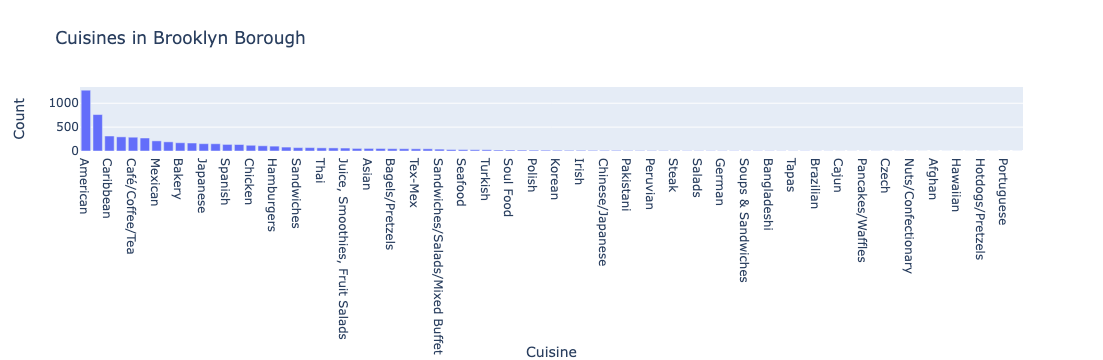

In [30]:
borough_lst = borough()
print(f'Boroughs in New York City: {borough_lst}')
borough_input = input('Enter a borough: ')
cuisines_in_borough(borough_input)

This visualization shows all the cuisines present in a user-inputted borough. The most popular cuisines in Brooklyn are 
American, Chinese, and Caribbean food. Some of the least popular cuisines in Brooklyn are Scandinavian, Portuguese, and 
Filipino. 